In [1]:
from evo.tools import log
log.configure_logging()
from evo.tools import plot
from evo.tools.plot import PlotMode
from evo.core.metrics import PoseRelation
from evo.core.units import Unit
from evo.tools.settings import SETTINGS

# temporarily override some package settings
SETTINGS.plot_figsize = [6, 6]
SETTINGS.plot_split = True
SETTINGS.plot_usetex = False

# magic plot configuration
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib widget

# interactive widgets configuration
import ipywidgets

check_opts_ape = {"align": False, "correct_scale": False, "show_plot": True}
check_boxes_ape=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_ape.items()]
check_opts_rpe = {"align": False, "correct_scale": False, "all_pairs": False, "show_plot": True}
check_boxes_rpe=[ipywidgets.Checkbox(description=desc, value=val) for desc, val in check_opts_rpe.items()]
delta_input = ipywidgets.FloatText(value=1.0, description='delta', disabled=False, color='black')
delta_unit_selector=ipywidgets.Dropdown(
    options={u.value: u for u in Unit if u is not Unit.seconds},
    value=Unit.frames, description='delta_unit'
)
plotmode_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PlotMode},
    value=PlotMode.xy, description='plot_mode'
)
pose_relation_selector=ipywidgets.Dropdown(
    options={p.value: p for p in PoseRelation},
    value=PoseRelation.translation_part, description='pose_relation'
)

agent_ids = [1,2]

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
from evo.tools import file_interface
from rosbags.rosbag2 import Reader as Rosbag2Reader
from rosbags.serde import deserialize_cdr
import math
import numpy as np
from scipy.spatial.transform import Rotation
from pathlib import Path
import os
from rosbags.typesys import get_types_from_idl, get_types_from_msg, register_types
import copy

# Add custom types
interfaces_dir = "../interfaces/msg/"
for file in os.listdir(interfaces_dir):
    msg_text = Path(interfaces_dir + file).read_text()
    register_types(get_types_from_msg(msg_text, "interfaces/msg/"+file[:-4]))


traj_ests = {}
traj_refs = {}
with Rosbag2Reader("/home/joshuabird/Desktop/MH_02-trajectory") as reader:
    # Read the trajectory and ground truth for each agent
    for agent_id in agent_ids:
        traj_est = file_interface.read_bag_trajectory(reader, f"/robot{agent_id}/camera_pose", transform_to_root_tf_frame_id="/world", use_final_tf_state=True)
        traj_ref = file_interface.read_bag_trajectory(reader, f"/robot{agent_id}/ground_truth_pose")

        traj_ests[agent_id] = traj_est
        traj_refs[agent_id] = traj_ref

[WARNING] geometry_msgs/PointStamped does not contain rotation, evo will use unit quaternion. Note that rotation metrics will be invalid and RPE will only be valid with point_distance metric.
[WARNING] geometry_msgs/PointStamped does not contain rotation, evo will use unit quaternion. Note that rotation metrics will be invalid and RPE will only be valid with point_distance metric.


In [3]:
from evo.core.trajectory import PosePath3DElement

filter_func: PosePath3DElement = lambda element: element["coord_frame"] == "robot1/origin"

# Filter to only the time range where trajectories are merged
for agent_id in agent_ids:
    traj_ests[agent_id].filter(filter_func)

# Trim them down to the shortest time range
# max_start_time = max([min(traj_ests[agent_id].timestamps) for agent_id in agent_ids])
# min_end_time = min([max(traj_ests[agent_id].timestamps) for agent_id in agent_ids])

# for agent_id in agent_ids:
#     traj_ests[agent_id].reduce_to_time_range(max_start_time, min_end_time)
#     traj_refs[agent_id].reduce_to_time_range(max_start_time, min_end_time)

In [4]:
for agent_id in agent_ids:
    print(traj_ests[agent_id])
    print(traj_refs[agent_id])

2527 poses, 113.323m path length, 131.650s duration
2257 poses, 70.451m path length, 134.612s duration
1891 poses, 94.064m path length, 101.050s duration
1675 poses, 57.970m path length, 100.508s duration


In [5]:
from evo.core import sync
from evo.core.trajectory import align_multiple

max_diff = 0.1

for agent_id in agent_ids:
    traj_refs[agent_id], traj_ests[agent_id] = sync.associate_trajectories(traj_refs[agent_id], traj_ests[agent_id], max_diff)
    
align_multiple(list(traj_ests.values()), list(traj_refs.values()), correct_scale=True)

[array([[ 0.16589588, -0.95282227, -0.25418158],
        [ 0.9845521 ,  0.14539539,  0.0975569 ],
        [-0.05599756, -0.26643929,  0.96222366]]),
 array([ 4.61945475, -1.70740957,  0.69347444]),
 0.645454684694564]

In [6]:
for agent_id in agent_ids:
    print(traj_refs[agent_id])
    print(traj_ests[agent_id])
    print()

2206 poses, 70.447m path length, 131.814s duration
2206 poses, 72.608m path length, 131.650s duration

1673 poses, 57.970m path length, 100.508s duration
1673 poses, 59.996m path length, 100.500s duration



interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…

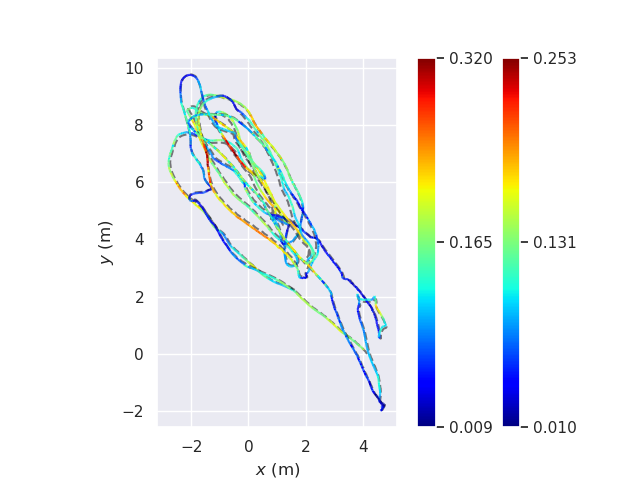

In [7]:
import evo.main_ape as main_ape
import evo.common_ape_rpe as common

count = 0
results = []

def callback_ape(pose_relation, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="APE Test #{}".format(count)
    
    fig = plt.figure()
    ax = plot.prepare_axis(fig, plot_mode)
    
    for agent_id in agent_ids:
        result = main_ape.ape(traj_refs[agent_id], traj_ests[agent_id], est_name=est_name,
                              pose_relation=pose_relation, align=align, correct_scale=correct_scale)
        results.append(result)

        if show_plot:
            plot.traj(ax, plot_mode, traj_refs[agent_id], style="--", alpha=0.5)
            plot.traj_colormap(
                ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
                min_map=result.stats["min"], max_map=result.stats["max"])
    count += 1
    
    
    
_ = ipywidgets.interact_manual(callback_ape, pose_relation=pose_relation_selector, plot_mode=plotmode_selector,
                               **{c.description: c.value for c in check_boxes_ape})

In [9]:
import evo.main_rpe as main_rpe

count = 0
results = []

def callback_rpe(pose_relation, delta, delta_unit, all_pairs, align, correct_scale, plot_mode, show_plot):
    global results, count
    est_name="RPE Test #{}".format(count)
    result = main_rpe.rpe(traj1_ref, traj1_est, est_name=est_name,
                          pose_relation=pose_relation, delta=delta, delta_unit=delta_unit, 
                          all_pairs=all_pairs, align=align, correct_scale=correct_scale, 
                          support_loop=True)
    count += 1
    results.append(result)
    
    if show_plot:
        fig = plt.figure()
        ax = plot.prepare_axis(fig, plot_mode)
        plot.traj(ax, plot_mode, traj1_ref, style="--", alpha=0.5)
        plot.traj_colormap(
            ax, result.trajectories[est_name], result.np_arrays["error_array"], plot_mode,
            min_map=result.stats["min"], max_map=result.stats["max"])

_ = ipywidgets.interact_manual(callback_rpe, pose_relation=pose_relation_selector, plot_mode=plotmode_selector, 
                               delta=delta_input, delta_unit=delta_unit_selector, 
                               **{c.description: c.value for c in check_boxes_rpe})

interactive(children=(Dropdown(description='pose_relation', index=1, options={'full transformation': <PoseRela…